In [1]:
#This part of code is copied from Andrew Ng Face Recognition
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first') #from now on every operation on keras will use [m,nc,nh,nw]
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
from PIL import Image
import h5py

%matplotlib inline
%load_ext autoreload
%autoreload 2
#the autoreload will make sure that the imported module will always be reloaded

np.set_printoptions(threshold=sys.maxsize) #This way no longer numpy array will be summarized, everything will be printed

Using TensorFlow backend.
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

In [2]:
_FLOATX = 'float32'


"""Define the dictionary key for the weights of the downloaded FaceNet. Naming rules are as follows:
    - If inception block is implemented, it will use 'inception' word in front of it
    - inception block will specify the size of the filter (or pool for maxpool)
    - when multiple conv or bn is implemented, it will give a number after the conv or bn (starting from 1)
    - the closing dense layer will have the name 'dense_layer'
"""
WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]
"""Define the shape for every convolution layer weight (keep in mind that this shape is not the same with the result)"""
conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'dense_layer': [128,736],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}
def variable(value, dtype = _FLOATX, name = None):
    """Converting usual variable into a tensor variable and initialize it.
    
    Arguments:
    value -- the value for the tensor variable
    dtype -- the variable type for the tensor variable, by default as float32
    name -- name of the variable if desired
    
    Return:
    v -- the tensor variable after initialized"""
    
    #convert the variable to np.asarray first just in case if the input is a variable
    v = tf.Variable(np.asarray(value, dtype = dtype), name=name)
    _get_session().run(v.initializer)
    return v

def shape(x):
    """Return the shape of the tensor
    
    Arguments:
    x -- a tensor
    
    Returns:
    x.get_shape() -- the shape of the given tensor"""
    return x.get_shape()

def square(x):
    """Square every value inside the tensor
    
    Arguments:
    x -- a tensor
    
    Returns:
    tf.square(x) -- a tensor with the value equals value of x squared"""
    return tf.square(x)

def zeros(shape, dtype = _FLOATX, name = None):
    """Create a variable of zeros with a given shape, type and name
    
    Arguments:
    shape -- the shape of the variable
    dtype -- the type of the value inside the variable, float32 will be the default
    name -- the name of the variable, by default it will be None
    
    Returns:
    a tensorflow variable with value all zero"""
    return variable(np.zeros(shape), dtype, name)

#def concatenate(tensors, axis = -1):
#    """Concat the tensors on the specified axis
    
#    Arguments:
#    tensors -- a list of tensors that are wanted to be concatenated together
#    axis -- the axis where they will be concatenated
    
#    Returns:
#    the concatenated tensors on the given axis
#    example: tf.concat([a,b], axis =0) where a and b shapes are [6,7] will give the result of shape
#    [12,7]. Note that concat is different than stack, where tf.stack([a,b], axis =0) will give the result
#    [2,6,7]."""
#    if axis < 0:
#       axis = axis % len(tensors[0].get_shape()) #-1 % 4 = 3
#    return tf.concat(axis = axis, values = tensors)

def LRN2D(x):
    """Return local response normalization layer of tensorflow, with alpha = 1e-4 and beta=0.75
    The alpha will be the weights of the added value (normalization constant), 
    and the beta will be the the one the power of the normalization (contrasting constant).
    The depth radius of the local reponse normalization will follow the default, which uses 5 channel
    depth as a default
    
    arguments:
    x -- the tensor to be normalized
    
    returns:
    the local response normalized tensor"""
    
    return tf.nn.local_response_normalization(x, alpha = 1e-4, beta = 0.75)

def conv2d_bn(x, layer = '', conv1Channel = None, cv1Filter = (1,1), cv1Strides = (1,1),
             conv2Channel = None, cv2Filter = (3,3), cv2Strides = (1,1), padding = None):
    """Implement a layer of combination between 2d convolutions, batch normalization and relu
    The convolution implemented will use a 'valid convolution'
    
    
    arguments:
    x -- input tensor
    layer -- string for the naming of the layer inside the conv2d and bn
    conv1Channel -- int for the desired number of channel for the conv1 output
    cv1Filter -- set with two int, indicating respectively the height and the width of the layer1
                conv filter
    cv1Strides -- set with two int, indicating respectively the height and the width of the layer1
                conv strides
    conv2Channel -- int for the desired number of channel for the conv2 output. Setting it to None
                    will not execute the conv2Channel
    cv1Filter -- set with two int, indicating respectively the height and the width of the layer2
                conv filter
    cv1Strides -- set with two int, indicating respectively the height and the width of the layer2
                conv strides
    padding -- the number of the padding that will bee used between the first convolution and the
                second convolution. Input can be one of the following:
                - (int,int) : the first int will be the height pad (respeectively), and the second int will be the width pad
                                (respectively)
                - (int) : respectively pad the height and the width with the given integerr
                - ((int,int), (int, int)) : pad the first tuple will be the pad of the height, with the format of (top,bottom)
                    the second tuple will be the pad for the width, with the format of (left, right)
                - None: will not execute the ZeroPadding2d
                
                
    Returns:
    x = the tensor after implemented with the desired convolution(s) and padding"""
    
    if conv1Channel == None:
        return x
    
    num = ''
    if(conv2Channel != None):
        num = 1
    #implement the first convolution, where it usually is the pointwise convolution by default (to implement bottleneck layer)
    x = Conv2D(conv1Channel, cv1Filter, strides = cv1Strides, data_format = "channels_first", name = layer+"_conv"+str(num))(x)
    x = BatchNormalization(axis = 1, epsilon = 0.00001, name = layer+"_bn"+str(num))(x)
    x = Activation("relu")(x)
    
    #if padding is none, directly return the result, this is done in case we need 1 convolution but we need to pad the result of the first conv
    if padding == None:
        return x
    x = ZeroPadding2D(padding, data_format = "channels_first")(x)
    
    #check whether it needs only one convolution
    if(conv2Channel == None):
        return x
    
    #implement the second convolution
    num = 2
    x = Conv2D(conv2Channel, cv2Filter, strides = cv2Strides, data_format = "channels_first", name = layer+"_conv"+str(num))(x)
    x = BatchNormalization(axis = 1, epsilon = 0.00001, name = layer+"_bn"+str(num))(x)
    x = Activation("relu")(x)
    return x

def load_weights():
    """Through the weights that is available inside the 'weights' folder. Each filter will be availabe in csv format and is comma separated.
    There are several kinds of layer type:
    - conv: there are w and b weights 
    - bn: there are w b m v weights
    - dense: there are w b weights
    
    Arguments:
    none, directly accessing the WEIGHTS and conv_shape global variables
    
    Returns:
    weights -- dictionary of weights obtained from the csv"""
    
    folder = "./weights" #this format means that it is a folder
    weights_dict = {} #initialize blank dictionary
    pathname = {}
    
    for i in os.listdir(folder):
        #get the pathname without the .csv
        pathname[i.replace(".csv", "")] = folder+"/"+i
    
    #np.genfromtxt converts contents of text file to our desired format 
    for i in WEIGHTS:
        if(os.path.isdir(i)):
            continue
            
        if "conv" in i:
            weights = np.genfromtxt(pathname[i+"_w"], delimiter = ",", dtype = None)
            #reshape annd transpose to channel_first form
            weights = np.reshape(weights, conv_shape[i])
            weights = np.transpose(weights, (2,3,1,0))
            
            bias = np.genfromtxt(pathname[i+"_b"], delimiter = ",", dtype = None)
            weights_dict[i] = [weights,bias]
        elif "bn" in i:
            weights = np.genfromtxt(pathname[i+"_w"], delimiter = ",", dtype = None)
            bias = np.genfromtxt(pathname[i+"_b"], delimiter = ",", dtype = None)
            mean = np.genfromtxt(pathname[i+"_m"], delimiter = ",", dtype = None)
            variance = np.genfromtxt(pathname[i+"_v"], delimiter = ",", dtype = None)
            weights_dict[i] = [weights,bias,mean,variance]
        elif "dense" in i:
            weights = np.genfromtxt(folder+"/dense_w.csv", delimiter = ",", dtype = None)
            #reshape annd transpose to channel_first form
            weights = np.reshape(weights, conv_shape[i])
            weights = np.transpose(weights, (1,0))
            
            bias = np.genfromtxt(folder+"/dense_b.csv", delimiter = ",", dtype = None)
            weights_dict[i] = [weights,bias]
    return weights_dict
def setWeightsToModel(FRModel):
    """Load the weights from the .csv files in weight (which was exporteed from Openface torch model) and set it into the Keras Model
    
    Arguments:
    FRModel -- The Keras FR Model that we want to set the weights
    
    Return:
    None, since the FRModel is a Keras Model (which is a Python Class), any changes inside the function will affect externally"""
    
    weights_dict = load_weights()
    
    for layerName in WEIGHTS:
        if FRModel.get_layer(layerName):
            FRModel.get_layer(layerName).set_weights(weights_dict[layerName])
        else:
            print("Error!")
            
def load_dataset():
    """Load the dataset from the train_happy.h5 and test_happy.h5
    
    arguments:
    None, directly accessing the files in 'datasets' directory
    
    return:
    train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes -- np array of respective categories"""
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def img_to_encoding(image_path, model):
    """Encode each image in database beforehand to save computation time
    
    arguments:
    image -- the path of the image file
    model -- the built keras model for FR
    
    Returns:
    embedding -- 128 encoded number nparray based on the encoding of the FRModel"""
    
    imgBGR = cv2.imread(image_path,1) #use cv2 so that the datatype is directly numpy array
    img = imgBGR[...,::-1] #flip to rgb
    img = np.transpose(img,(2,0,1)) #to convert to channel_first format
    img = np.around(img/255.0, decimals = 12) #divide by 255 to normalize and round it to only 12 decimal numbers
    
    #increase the dimension so it becomes [1,img.shape] shape
    predict = np.array([img])
    embedding = model.predict(predict)
    return embedding


In [3]:
def inceptionBlock3a(X):
    """Implement the 3a inception block of OpenFace. Here are the numbers
    of the channels per filter:
    - 1x1 = 64
    - 3x3(reduce) = 96
    - 3x3 = 128
    - 5x5(reduce) = 16
    - 5x5 = 32
    - pool = max, 32p
    
    Arguments:
    X = Input tensors from the previous process. Channel_first
    
    Returns:
    Concatenated inception tensors in the order of 3x3, 5x5, pool and 1x1"""
    
    #doing the 3x3 first
    #the first step is to reduce the dimension for easier convolution
    Conv3x3 = conv2d_bn(X, layer = "inception_3a_3x3", 
                        conv1Channel = 96, cv1Filter=(1,1), cv1Strides = (1,1),
                       conv2Channel = 128, cv2Filter = (3,3), cv2Strides = (1,1), 
                        padding = (1,1))
    
    #doing the 5x5 convolution next
    #the first step is to reduce the dimension for easier convolution
    Conv5x5 = conv2d_bn(X, layer = "inception_3a_5x5", conv1Channel = 16, 
                        cv1Filter=(1,1), cv1Strides = (1,1),
                       conv2Channel = 32, cv2Filter = (5,5), 
                        cv2Strides = (1,1), padding = (2,2))
    
    #beginning the pool part
    Pool = MaxPooling2D((3,3), 2)(X)
    Pool = conv2d_bn(Pool, layer = "inception_3a_pool", conv1Channel = 32, 
                     cv1Filter=(1,1), cv1Strides = (1,1), 
                     padding = ((3,4), (3,4)))
    
    #Beginning the 1x1 convolution part
    Conv1x1 = conv2d_bn(X, layer = "inception_3a_1x1", 
                        conv1Channel = 64, cv1Filter=(1,1), 
                        cv1Strides = (1,1))
    
    #concat everything and return
    return concatenate([Conv3x3, Conv5x5, Pool, Conv1x1], axis = 1)
    
def inceptionBlock3b(X):
    """Implement the 3b inception block of OpenFace. Here are the numbers
    of the channels per filter:
    - 1x1 = 64
    - 3x3(reduce) = 96
    - 3x3 = 128
    - 5x5(reduce) = 32
    - 5x5 = 64
    - pool = l2(average pooling), 64p
    
    Arguments:
    X = Input tensors from the previous process. Channel_first
    
    Returns:
    Concatenated inception tensors in the order of 3x3, 5x5, pool and 1x1"""
    
    #doing the 3x3 version
    Conv3x3 = conv2d_bn(X, layer = "inception_3b_3x3", conv1Channel = 96, 
                        cv1Filter=(1,1), cv1Strides = (1,1),
                       conv2Channel = 128, cv2Filter = (3,3), 
                        cv2Strides = (1,1), padding = (1,1))
    
    #doing the 5x5 version
    Conv5x5 = conv2d_bn(X, layer = "inception_3b_5x5", conv1Channel = 32, cv1Filter=(1,1), 
                        cv1Strides = (1,1), conv2Channel = 64, cv2Filter = (5,5), 
                        cv2Strides = (1,1), padding = (2,2))
    
    #doing the pool version
    Pool = AveragePooling2D((3,3), strides = (3,3))(X)
    Pool = conv2d_bn(Pool, layer = "inception_3b_pool", conv1Channel = 64, 
                     cv1Filter=(1,1), cv1Strides = (1,1), padding = (4,4))
    
    Conv1x1 = conv2d_bn(X, layer = "inception_3b_1x1", conv1Channel = 64, cv1Filter=(1,1), cv1Strides = (1,1))
    
    return concatenate([Conv3x3, Conv5x5, Pool, Conv1x1], axis = 1)


def inceptionBlock3c(X):
    """Implement the 3c inception block of OpenFace. Here are the numbers
    of the channels per filter:
    - 3x3(reduce) = 128
    - 3x3 = 256, strides 2
    - 5x5(reduce) = 32
    - 5x5 = 64, strides 2
    - pool = m(max pooling), 3x3, 2
    
    Arguments:
    X = Input tensors from the previous process. Channel_first
    
    Returns:
    Concatenated inception tensors in the order of 3x3, 5x5, pool"""
        
    Conv3x3 = conv2d_bn(X, layer = "inception_3c_3x3", conv1Channel = 128, 
                        cv1Filter=(1,1), cv1Strides = (1,1),
                       conv2Channel = 256, cv2Filter = (3,3), 
                        cv2Strides = (2,2), padding = (1,1))
    Conv5x5 = conv2d_bn(X, layer = "inception_3c_5x5", conv1Channel = 32, 
                        cv1Filter=(1,1), cv1Strides = (1,1),
                       conv2Channel = 64, cv2Filter = (5,5), 
                        cv2Strides = (2,2), padding = (2,2))
    
    #beginning the pooling part
    Pool = MaxPooling2D((3,3), strides = (2,2))(X)
    Pool = ZeroPadding2D(((0,1), (0,1)))(Pool)
    return concatenate([Conv3x3, Conv5x5, Pool], axis = 1)

def inceptionBlock4a(X):
    """Implement the 4a inception blcok of OpenFace. Here are the numbers
    of the channels per filter:
    - 1x1 = 256
    - 3x3(reduce) = 96
    - 3x3 = 192
    - 5x5(reduce) = 32
    - 5x5 = 64
    - pool = l2(average pooling), 128p
    
    Arguments:
    X = Input tensors from the previous process. Channel_first
    
    Returns:
    Concatenated inception tensors in the order of 3x3, 5x5, pool,1x1"""
    
    Conv3x3 =  conv2d_bn(X, layer = "inception_4a_3x3", conv1Channel = 96, 
                         cv1Filter=(1,1), cv1Strides = (1,1), conv2Channel = 192, cv2Filter = (3,3), 
                         cv2Strides = (1,1), padding = (1,1))
    Conv5x5 = conv2d_bn(X, layer = "inception_4a_5x5", conv1Channel = 32, 
                        cv1Filter=(1,1), cv1Strides = (1,1), conv2Channel = 64, cv2Filter = (5,5), 
                        cv2Strides = (1,1), padding = (2,2))
    
    #beginning the pooling part
    Pool = AveragePooling2D((3,3), strides = (3,3))(X)
    Pool = conv2d_bn(Pool, layer = "inception_4a_pool", conv1Channel = 128, 
                     cv1Filter=(1,1), cv1Strides = (1,1), padding = (2,2))
    
    Conv1x1 = conv2d_bn(X, layer = "inception_4a_1x1", conv1Channel = 256, cv1Filter=(1,1), cv1Strides = (1,1))
    
    return concatenate([Conv3x3, Conv5x5, Pool, Conv1x1], axis = 1)
def inceptionBlock4e(X):
    """Implement the 4e inception blcok of OpenFace. Here are the numbers
    of the channels per filter:
    - 3x3(reduce) = 160
    - 3x3 = 256, strides = 2
    - 5x5(reduce) = 64
    - 5x5 = 128, strides = 2
    - pool = m(max pooling), 3x3,2
    
    Arguments:
    X = Input tensors from the previous process. Channel_first
    
    Returns:
    Concatenated inception tensors in the order of 3x3, 5x5, pool,1x1"""
    
    Conv3x3 =  conv2d_bn(X, layer = "inception_4e_3x3", conv1Channel = 160, 
                         cv1Filter=(1,1), cv1Strides = (1,1), conv2Channel = 256, 
                         cv2Filter = (3,3), cv2Strides = (2,2), padding = (1,1))
    Conv5x5 = conv2d_bn(X, layer = "inception_4e_5x5", conv1Channel = 64, cv1Filter=(1,1), 
                        cv1Strides = (1,1), conv2Channel = 128, cv2Filter = (5,5), 
                        cv2Strides = (2,2), padding = (2,2))
    
    #beginning the pooling part
    Pool = MaxPooling2D((3,3), strides = (2,2))(X)
    Pool = ZeroPadding2D(((0,1), (0,1)))(Pool)
    
    return concatenate([Conv3x3, Conv5x5, Pool], axis = 1)
def inceptionBlock5a(X):
    """Implement the 5a inception blcok of OpenFace. Here are the numbers
    of the channels per filter:
    - 1x1 = 256
    - 3x3(reduce) = 96
    - 3x3 = 384
    - pool = l2(average pooling), 96p
    
    Arguments:
    X = Input tensors from the previous process. Channel_first
    
    Returns:
    Concatenated inception tensors in the order of 3x3, pool,1x1"""
    
    Conv3x3 =  conv2d_bn(X, layer = "inception_5a_3x3", conv1Channel = 96, 
                         cv1Filter=(1,1), cv1Strides = (1,1), conv2Channel = 384, 
                         cv2Filter = (3,3), cv2Strides = (1,1), padding = (1,1))
    
    #beginning the pooling part
    Pool = AveragePooling2D((3,3), strides = (3,3))(X)
    Pool = conv2d_bn(Pool, layer = "inception_5a_pool", conv1Channel = 96, 
                     cv1Filter=(1,1), cv1Strides = (1,1), padding = (1,1))
    
    Conv1x1 = conv2d_bn(X, layer = "inception_5a_1x1", conv1Channel = 256, 
                        cv1Filter=(1,1), cv1Strides = (1,1))
    
    return concatenate([Conv3x3, Pool, Conv1x1], axis = 1)
def inceptionBlock5b(X):
    """Implement the 5b inception blcok of OpenFace. Here are the numbers
    of the channels per filter:
    - 1x1 = 256
    - 3x3(reduce) = 96
    - 3x3 = 384
    - pool = m(max pooling), 96p
    
    Arguments:
    X = Input tensors from the previous process. Channel_first
    
    Returns:
    Concatenated inception tensors in the order of 3x3, pool, 1x1"""
    
    Conv3x3 =  conv2d_bn(X, layer = "inception_5b_3x3", conv1Channel = 96, 
                         cv1Filter=(1,1), cv1Strides = (1,1), conv2Channel = 384, 
                         cv2Filter = (3,3), cv2Strides = (1,1), padding = (1,1))
    
    #beginning the pooling part
    Pool = MaxPooling2D((3,3), strides = (2,2))(X)
    Pool = conv2d_bn(Pool, layer = "inception_5b_pool", conv1Channel = 96, 
                     cv1Filter=(1,1), cv1Strides = (1,1), padding = (1,1))
    
    Conv1x1 = conv2d_bn(X, layer = "inception_5b_1x1", conv1Channel = 256, 
                        cv1Filter=(1,1), cv1Strides = (1,1))
    
    return concatenate([Conv3x3, Pool, Conv1x1], axis = 1)
def faceRecoModel(input_shape):
    """
    Implemention of the Incepttion model used for FaceNet
    
    Arguments:
    input_shape -- (channel,height,width)
    
    Returns:
    FRModel -- FaceNet Keras implementation model
    
    since in the beginning we have set the data format to channel_first by default, we don't need to do anything"""
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3,3))(X_input) #pad the beginning
    
    #begin the first block
    X = Conv2D(64,(7,7), strides = (2,2), name = "conv1")(X)
    X = BatchNormalization(axis = 1, name = "bn1")(X)
    X = Activation("relu")(X)
    
    #ZeroPadding + MaxPool
    X = ZeroPadding2D((1,1))(X)
    X = MaxPooling2D((3,3), strides = 2)(X)
    
    #begin the second Conv
    X = Conv2D(64, (1,1), strides = (1,1), name = "conv2")(X)
    X = BatchNormalization(axis = 1, epsilon = 0.00001, name = "bn2")(X)
    X = Activation("relu")(X)
    
    #ZeroPadding
    X = ZeroPadding2D((1,1))(X)
    
    #begin the third conv
    X = Conv2D(192, (3,3), name = "conv3")(X)
    X = BatchNormalization(axis = 1, name = "bn3")(X)
    X = Activation("relu")(X)
    
    #ZeroPadding and Relu
    X = ZeroPadding2D((1,1))(X)
    X = MaxPooling2D((3,3), strides = 2)(X)
    
    #Beginning inception
    X = inceptionBlock3a(X)
    X = inceptionBlock3b(X)
    X = inceptionBlock3c(X)
    X = inceptionBlock4a(X)
    X = inceptionBlock4e(X)
    X = inceptionBlock5a(X)
    X = inceptionBlock5b(X)
    
    
    #beginning the final 3 layerrs
    X = AveragePooling2D((3,3), strides = (1,1))(X)
    X = Flatten()(X)
    X = Dense(128, name = "dense_layer")(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)
    
    model = Model(inputs = X_input, outputs = X)
    return model

In [4]:
#The detail of the face recognition model will be implemented inside the inception_blocks_v2.py
FRmodel = faceRecoModel(input_shape = (3,96,96)) #since now the order will be channel_first, the 3 channel will be placed on the beginning
print("Total Params: ", FRmodel.count_params())



Total Params:  3743280


In [5]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss used to measure the squared l2-norm of anchor-positive and anchor-negative
    
    Arguments:
    y_true -- True labels that is required when we define our own custom loss function (although it is left unused)
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    alpha -- alpha to be inserted inside the triple loss function, set to 0.2 by default
    
    Note: the None right here symbolizes the amount of the data
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    l2Pos = tf.reduce_sum(tf.square(anchor-positive),axis = -1)
    
    l2Neg = tf.reduce_sum(tf.square(anchor-negative), axis = -1)
    
    lossAmount  = tf.reduce_sum(tf.maximum(l2Pos-l2Neg+alpha, 0.0))
    
    return lossAmount

In [6]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 528.1432


In [7]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
setWeightsToModel(FRmodel) #this function is already defined inside the frutils, basically it set the weights of the layers

In [8]:
#encode the coding first beforehand
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

In [9]:
#make the verify function for face verification
def verify(image_path, identity, database, model):
    """face verification function to make sure that the person inside the image matches the identity in the database. 
    
     Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    #encode the image first
    toBeVerified = img_to_encoding(image_path, model)
    
    #count the l2 distance to check if it is lower than a threshold (0.7)
    distance = np.linalg.norm(toBeVerified - database[identity])
    
    if(distance < 0.7):
        print(f"Hi {identity}, welcome in!")
        door_open = True
    else:
        print(f"You're not {identity}, shoo!")
        door_open = False
    
    return distance, door_open
    

In [10]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

Hi younes, welcome in!


(0.67094606, True)

You're not kian, shoo!


(0.8581549, False)

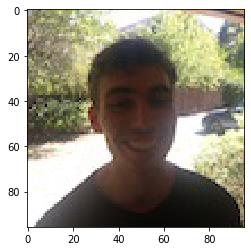

In [11]:
image= Image.open("images/camera_2.jpg")
plt.imshow(image)
verify("images/camera_2.jpg", "kian", database, FRmodel)

In [12]:
def recognition(images_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- dictionary containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    encoded = img_to_encoding(images_path,model)
    
    min_dist = 100 #for now let's just set to 100
    nameFinal = None
    for name,face_encode in database.items():
        distance = np.linalg.norm(encoded-face_encode)
        if(distance < min_dist):
            min_dist = distance
            nameFinal = name
            
    if min_dist > 0.7:
        print("Not recognized")
    else:
        print(f"Hi {nameFinal}!")
    return min_dist, nameFinal

Hi younes!


(0.67094606, 'younes')

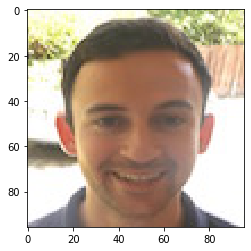

In [13]:
image= Image.open("images/camera_0.jpg")
plt.imshow(image)
recognition("images/camera_0.jpg", database, FRmodel)

In [14]:
for i in os.listdir("./weights"):
    if(os.path.isfile(i)):
        print(i)
    else:
        print("False")

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [15]:
for i in os.listdir():
    print(os.path.isdir(i))

True
True
False
False
True
False
False
True
True


In [16]:
class Dog():
    def __init__(self, a):
        self.leg = a
def changingValue(a):
    a.leg = 10
def changingValue(a):
    a.leg = 2
a = Dog(1)
changingValue(a)
print(a.leg)

2
